In [1]:
import pandas as pd
import numpy as np
w=[]
#os=[]
n=0
with open ('Eu_bpdo_gopt_dipmom.out') as f:
        for row in f:
            if 'Matrix TX' in row:
                n+=1
            if n==2:
                #line=next(f)
                print(row)
                 
    

In [3]:
from os import remove
from os.path import join
from re import compile, search, findall
from numpy import (
    ndarray,
    array,
    ascontiguousarray,
    zeros,
    empty,
    any,
    diagonal,
    int64,
    float64,
    complex128,
)
from h5py import File
from typing import Tuple
from numpy.linalg import eigh, eigvalsh

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
def gaussian(x, mu, sigma, area):
    normalization = area / (sigma * np.sqrt(2 * np.pi))
    return normalization * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def lorentzian(x, mu, gamma, area):
    
    return area / (np.pi) * (gamma) / ((x - mu)**2 + gamma**2)
def convolute_spectral_lines_l(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += lorentzian(x_values, energy, sigma, area)

    return x_values, conv_spectrum

def convolute_spectral_lines_g(energies, intensities, fwhm, resolution=1000):
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    x_min, x_max = min(energies) - 5 * fwhm, max(energies) + 5 * fwhm
    x_values = np.linspace(x_min, x_max, resolution)
    conv_spectrum = np.zeros_like(x_values)

    for energy, intensity in zip(energies, intensities):
        area = intensity  # Assuming intensity is proportional to the desired area
        conv_spectrum += gaussian(x_values, energy, sigma, area)

    return x_values, conv_spectrum
def relative_boltzmann_distribution(x, y, T):

    k = 3.166811563e-6  # Boltzmann constant in a.u./K
    delta_E = y - x   # Energy difference

    return np.exp(-delta_E / (k * T))

In [5]:
def _get_orca_so_blocks_size(
    path: str, orca_file: str
) -> tuple[int, int, int, int]:
    orca_file_path = join(path, orca_file)
    
    with open(orca_file_path, "r") as file:
        content = file.read()

    so_dim_match = search(r"Dim\(SO\)\s+=\s+(\d+)", content)
    if so_dim_match:
        so_dim = int(so_dim_match.group(1))
    else:
        raise ValueError("Dim(SO) not found in the ORCA file.")

    num_blocks = so_dim // 6

    if so_dim % 6 != 0:
        num_blocks += 1

    block_size = ((so_dim + 1) * num_blocks) + 1
    num_of_whole_blocks = so_dim // 6
    remaining_columns = so_dim % 6

    return so_dim, block_size, num_of_whole_blocks, remaining_columns

In [7]:
def _orca_spin_orbit_to_slt(
    path_orca: str,
    inp_orca: str,
    path_out: str,
    hdf5_output: str,
    name: str,
    pt2: bool = False,
) -> None:
    """
    Converts spin-orbit calculations from an ORCA .out file to
    a HDF5 file format.

    Args:
        path_orca (str): Path to the ORCA file.
        inp_orca (str): Name of the ORCA file.
        path_out (str): Path for the output files.
        hdf5_output (str): Name of the HDF5 output file.
        pt2 (bool): Get results from the second-order perturbation-corrected
                    states.

    Raises:
        ValueError: If the spin-orbit dimension is not found in the ORCA file.
        ValueError: If the pattern is not found in the input file.
    """
    hdf5_file = join(path_out, hdf5_output)

    # Retrieve dimensions and block sizes for spin-orbit calculations
    (
        so_dim,
        block_size,
        num_of_whole_blocks,
        remaining_columns,
    ) = _get_orca_so_blocks_size(path_orca, inp_orca)

    # Create HDF5 file and ORCA group
    output = File(f"{hdf5_file}.slt", "a")
    orca = output.create_group(str(name))
    orca.attrs["Description"] = (
        f"Group({name}) containing results of relativistic SOC ORCA"
        " calculations - angular momenta and SOC matrix in CI basis"
    )
    # Extract and process matrices (SX, SY, SZ, LX, LY, LZ)
    matrices = ["TX", "TY", "TZ"]
   
    for matrix_name in matrices:
        pattern = f"Matrix {matrix_name}\n"
        regex = compile(pattern)


        with open(inp_orca, "r") as file:
            for line in file:
                #for _ in range(1):
                    if regex.search(line):
                        if pt2:
                            for _ in range(block_size + 5):
                                file.readline()  # Skip non-pt2 block
                        for _ in range(3):
                            file.readline()  # Skip the first 3 lines
                        matrix = empty((so_dim, so_dim), dtype=float64)
                        l = 0
                        for _ in range(2):
                            file.readline()  # Skip a line before each block of 6 columns
                            for i in range(so_dim):
                                line = file.readline().split()
                                for j in range(6):
                                    matrix[i, l + j] = float64(line[j + 1])
                            l += 6
                
                        if remaining_columns > 0:
                            file.readline()  # Skip a line before the remaining columns
                            for i in range(so_dim):
                                line = file.readline().split()
                                for j in range(remaining_columns):
                                    matrix[i, l + j] = float64(line[j + 1])
                             
                        # Create dataset in HDF5 file and assign the matrix
                        dataset = np.array(
                            f"SF_{matrix_name}", shape=(so_dim, so_dim), dtype=float64
                        )
                        dataset[:, :] = matrix[:, :]
                        
    
                    
                               


                
    regex = compile("SOC MATRIX \(A\.U\.\)\n")
    with open(inp_orca, "r") as file:
        for line in file:
            if regex.search(line):
                if pt2:
                    for _ in range(2 * block_size + 5 + 2):
                        file.readline()  # Skip non-pt2 block
                for _ in range(3):
                    file.readline()  # Skip the first 3 lines

                matrix_real = empty((so_dim, so_dim), dtype=float64)
                l = 0
                for _ in range(num_of_whole_blocks):
                    file.readline()  # Skip a line before each block of 6 columns
                    for i in range(so_dim):
                        line = file.readline()
                        elements = findall(r'[-+]?\d*\.\d+', line)
                        for j in range(6):       
                            matrix_real[i, l + j] = float64(elements[j])
                    l += 6
                    
                if remaining_columns > 0:
                    file.readline()  # Skip a line before the remaining columns
                    for i in range(so_dim):
                        line = file.readline()
                        elements = findall(r'[-+]?\d*\.\d+', line)
                        for j in range(remaining_columns):
                            matrix_real[i, l + j] = float64(elements[j])   
                        
                
                for _ in range(2):
                    file.readline()  # Skip 2 lines separating real and imaginary part
            
                matrix_imag = empty((so_dim, so_dim), dtype=float64)
                l = 0
                for _ in range(num_of_whole_blocks):
                    file.readline()  # Skip a line before each block of 6 columns
                    for i in range(so_dim):
                        line = file.readline()
                        elements = findall(r'[-+]?\d*\.\d+', line)
                        for j in range(6):       
                            matrix_imag[i, l + j] = float64(elements[j])
                    l += 6
                    
                if remaining_columns > 0:
                    file.readline()  # Skip a line before the remaining columns
                    for i in range(so_dim):
                        line = file.readline()
                        elements = findall(r'[-+]?\d*\.\d+', line)
                        for j in range(remaining_columns):
                            matrix_imag[i, l + j] = float64(elements[j])

        
    
    dip_mom = zeros((3, shape, shape), dtype=complex128)
    soc_mat = matrix_real[:]
    dip_mom[0][:] = ["SF_TX"][:]
    dip_mom[1][:] = ["SF_TY"][:]
    dip_mom[2][:] = ["SF_TZ"][:]



                    
        
                    
            
    soc_energies, eigenvectors = eigh(soc_mat)
    dip_mom_soc = (eigenvectors.conj().T @ dip_mom @ eigenvectors)

In [8]:
so_dim=3003
num_of_whole_blocks = so_dim// 6
remaining_columns = so_dim % 6
num_blocks = so_dim // 6
if so_dim% 6 != 0:
    num_blocks += 1
block_size = ((so_dim+ 1) * num_blocks) + 1

pt2=False

hdf5_file = join('.', 'test_dipmom2')
name='bas'
output = File(f"{hdf5_file}.slt", "a")
orca = output.create_group(str(name))
orca.attrs["Description"] = (
        f"Group({name}) containing results of relativistic SOC ORCA"
        " calculations - angular momenta and SOC matrix in CI basis")
matrices = ["TX", "TY", "TZ"]


for matrix_name in matrices:
    pattern = f"Matrix {matrix_name}\n"
    regex = compile(pattern)

    n=0
    with open('Eu_bpdo_gopt_dipmom.out', "r") as file:
        if pt2:
            for line in file:
                if regex.search(line):
                    n+=1
                    if n==2:
                        matrix = empty((so_dim, so_dim), dtype=float64)
                        l = 0
                        for _ in range(2):
                            file.readline()  # Skip a line before each block of 6 columns
                            for i in range(so_dim):
                                line = file.readline().split()
                                #print(line)
                                for j in range(6):
                                    matrix[i, l + j] = float64(line[j + 1])
                            l += 6
                
                        if remaining_columns > 0:
                            file.readline()  # Skip a line before the remaining columns
                            for i in range(so_dim):
                                line = file.readline().split()
                                for j in range(remaining_columns):
                                    matrix[i, l + j] = float64(line[j + 1])
                             
                        # Create dataset in HDF5 file and assign the matrix
                        
                        dataset = orca.create_dataset(
                                f"{matrix_name}", shape=(so_dim, so_dim), dtype=float64
                            )
                        dataset[:, :] = matrix[:, :]
        else:
            n=0
            for line in file:
                    if regex.search(line):
                        n+=1
                        if n==1:
                        
                            matrix = empty((so_dim, so_dim), dtype=float64)
                            l = 0
                            for _ in range(2):
                                file.readline()  # Skip a line before each block of 6 columns
                                for i in range(so_dim):
                                    line = file.readline().split()
                                    #print(line)
                                    for j in range(6):
                                        matrix[i, l + j] = float64(line[j + 1])
                                l += 6
                    
                            if remaining_columns > 0:
                                file.readline()  # Skip a line before the remaining columns
                                for i in range(so_dim):
                                    line = file.readline().split()
                                    for j in range(remaining_columns):
                                        matrix[i, l + j] = float64(line[j + 1])
                                 
                            # Create dataset in HDF5 file and assign the matrix
                            
                            dataset = orca.create_dataset(
                                    f"{matrix_name}", shape=(so_dim, so_dim), dtype=float64
                                )
                            dataset[:, :] = matrix[:, :]   

regex = compile("SOC MATRIX \(A\.U\.\)\n")
n=0
with open('Eu_bpdo_gopt_dipmom.out', "r") as file:
    if pt2:
        for line in file:
            if regex.search(line):
                n+=1
                if n==2:
                    for _ in range(3):
                        file.readline()  # Skip the first 3 lines
        
                    matrix_real = empty((so_dim, so_dim), dtype=float64)
                    l = 0
                    for _ in range(num_of_whole_blocks):
                        file.readline()  # Skip a line before each block of 6 columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(6):       
                                matrix_real[i, l + j] = float64(elements[j])
                        l += 6
                        
                    if remaining_columns > 0:
                        file.readline()  # Skip a line before the remaining columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(remaining_columns):
                                matrix_real[i, l + j] = float64(elements[j])   
                            
                    
                    for _ in range(2):
                        file.readline()  # Skip 2 lines separating real and imaginary part
                
                    matrix_imag = empty((so_dim, so_dim), dtype=float64)
                    l = 0
                    for _ in range(num_of_whole_blocks):
                        file.readline()  # Skip a line before each block of 6 columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(6):       
                                matrix_imag[i, l + j] = float64(elements[j])
                        l += 6
                        
                    if remaining_columns > 0:
                        file.readline()  # Skip a line before the remaining columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(remaining_columns):
                                matrix_imag[i, l + j] = float64(elements[j])



    else:
        n=0
        for line in file:
            if regex.search(line):
                n+=1
                if n==1:
                    for _ in range(3):
                        file.readline()  # Skip the first 3 lines
        
                    matrix_real = empty((so_dim, so_dim), dtype=float64)
                    l = 0
                    for _ in range(num_of_whole_blocks):
                        file.readline()  # Skip a line before each block of 6 columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(6):       
                                matrix_real[i, l + j] = float64(elements[j])
                        l += 6
                        
                    if remaining_columns > 0:
                        file.readline()  # Skip a line before the remaining columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(remaining_columns):
                                matrix_real[i, l + j] = float64(elements[j])   
                            
                    
                    for _ in range(2):
                        file.readline()  # Skip 2 lines separating real and imaginary part
                
                    matrix_imag = empty((so_dim, so_dim), dtype=float64)
                    l = 0
                    for _ in range(num_of_whole_blocks):
                        file.readline()  # Skip a line before each block of 6 columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(6):       
                                matrix_imag[i, l + j] = float64(elements[j])
                        l += 6
                        
                    if remaining_columns > 0:
                        file.readline()  # Skip a line before the remaining columns
                        for i in range(so_dim):
                            line = file.readline()
                            elements = findall(r'[-+]?\d*\.\d+', line)
                            for j in range(remaining_columns):
                                matrix_imag[i, l + j] = float64(elements[j])
        
        
        
        
        
        
        dip_mom = zeros((3, 3003, 3003), dtype=complex128)
        soc_mat = matrix_real[:]+1j*matrix_imag[:]
        dip_mom[0][:] = output[str(name)]["TX"][:]
        dip_mom[1][:] = output[str(name)]["TY"][:]
        dip_mom[2][:] = output[str(name)]["TZ"][:]
        soc_energies, eigenvectors = eigh(soc_mat)
        dip_mom_soc = (eigenvectors.conj().T @ dip_mom @ eigenvectors)


    

BlockingIOError: [Errno 11] Unable to synchronously open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [7]:
dip_mom.shape

(3, 3003, 3003)

In [8]:
soc_energies

array([-13400.31242328, -13400.3108772 , -13400.31086719, ...,
       -13399.40375107, -13399.40340042, -13399.25681138])

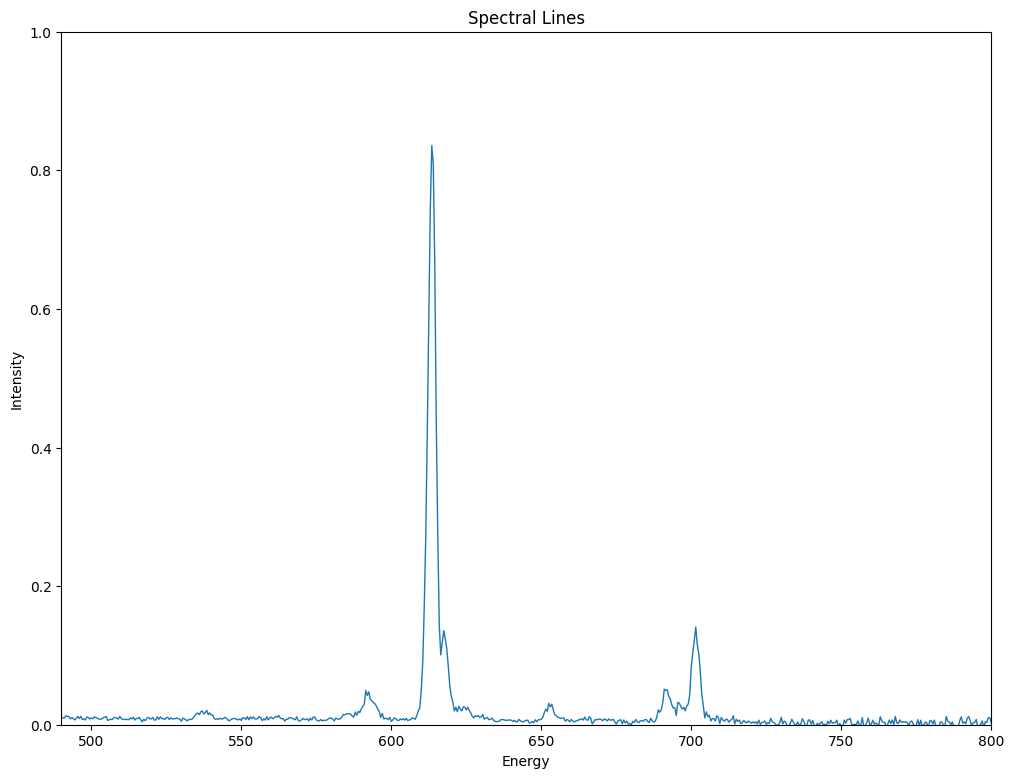

In [17]:
# EMISSION
F = [[ 49]]
temperatures = np.linspace(10,10, 1)
fwhm = 150
normalize = 1
resolution = 20000
sum_spectra = np.zeros((resolution, ), dtype=np.float64)


fig, axs = plt.subplots(1, 1, figsize=(12, 9))
index = 0

results = pd.DataFrame()


energies = soc_energies[:]
energies = (energies - energies[0])
dipmom = dip_mom_soc[:]    

  
for index, F_emissive in enumerate(F):
    for T in temperatures:    
        intensities = np.zeros((len(F_emissive), 49), dtype = np.float64)
        emission_energies_cm = np.zeros((len(F_emissive), 49), dtype = np.float64)
        for l, level in enumerate(F_emissive):
            for i in range(49):
                for k in range(3):
                    intensities[l,i] += relative_boltzmann_distribution(energies[F_emissive[0]], energies[level], T) * 2/3 * np.abs(dipmom[k, i, level])**2 * (energies[level] - energies[i])
                    emission_energies_cm[l,i] = ((energies[level] - energies[i]) * 219474.6)
        intensities = intensities.flatten()
        emission_energies_cm = emission_energies_cm.flatten()
        intensities = intensities/max(intensities)
        emission_energies_nm = 1e7/emission_energies_cm
        energy_x_cm, spectrum = convolute_spectral_lines_g(emission_energies_cm, intensities, fwhm, resolution)
        spectrum = spectrum/max(spectrum) 
        sum_spectra += spectrum
        energy_x_nm = 1e7/energy_x_cm
      
        
        
    
        
        #if T == 10:
            #axs.vlines(x=emission_energies_nm, ymin=0, ymax=intensities, label="T")
#axs.plot(energy_x_nm, spectrum, label=f'{T}')


        


axs.set_xlabel('Energy')
axs.set_ylabel('Intensity')
axs.set_title('Spectral Lines')
axs.set_xlim([490, 800])
axs.set_ylim([0,normalize])

df = pd.read_csv('Eu_bpdo_exp.txt',sep='\t')
df[df.columns[0]]=df[df.columns[0]].str.replace(',','.').astype(float)
df[df.columns[1]]=df[df.columns[1]].str.replace(',','.').astype(float)
axs.plot(df[df.columns[0]], df[df.columns[1]]/df[df.columns[1]].max(), linewidth=1.0)

In [ ]:
df = pd.read_csv('Eu_bpdo_exp.txt',sep='\t')
w=[]
int=[]
df[df.columns[0]]=df[df.columns[0]].str.replace(',','.').astype(float)
  
df[df.columns[0]]

In [ ]:
energies = soc_energies[:]
energies = (energies - energies[0])
energies*219474.6

In [ ]:
df = pd.read_csv('Yb_bpdo_exp.csv',sep=';')
#axs.plot(df[df.columns[0]], df[df.columns[1]]/df[df.columns[1]].max(), linewidth=1.0)
df[df.columns[0]]

In [ ]:
so_dim=14
num_of_whole_blocks = so_dim// 6
remaining_columns = so_dim % 6
num_blocks = so_dim // 6
if so_dim% 6 != 0:
    num_blocks += 1
block_size = ((so_dim+ 1) * num_blocks) + 1

pt2=False

hdf5_file = join('.', 'test_dipmom')
name='bas30'
output = File(f"{hdf5_file}.slt", "a")
orca = output.create_group(str(name))
orca.attrs["Description"] = (
        f"Group({name}) containing results of relativistic SOC ORCA"
        " calculations - angular momenta and SOC matrix in CI basis")



matrices = ["TX", "TY", "TZ"]


for matrix_name in matrices:
    pattern = f"Matrix {matrix_name}\n"
    regex = compile(pattern)


    with open('Yb_bpdo_soc_bezopt_dipmom.out', "r") as file:
        for line in file:
            #for _ in range(1):
                if regex.search(line):
                    if pt2:
                        for _ in range(block_size + 5):
                            file.readline()  # Skip non-pt2 block
                    #for _ in range(1):
                        #file.readline()  # Skip the first 3 lines
                    matrix = empty((so_dim, so_dim), dtype=float64)
                    l = 0
                    for _ in range(2):
                        file.readline()  # Skip a line before each block of 6 columns
                        for i in range(so_dim):
                            line = file.readline().split()
                            #print(line)
                            for j in range(6):
                                matrix[i, l + j] = float64(line[j + 1])
                        l += 6
            
                    if remaining_columns > 0:
                        file.readline()  # Skip a line before the remaining columns
                        for i in range(so_dim):
                            line = file.readline().split()
                            for j in range(remaining_columns):
                                matrix[i, l + j] = float64(line[j + 1])
                         
                    # Create dataset in HDF5 file and assign the matrix
                    
                    dataset = orca.create_dataset(
                            f"{matrix_name}", shape=(so_dim, so_dim), dtype=float64
                        )
                    dataset[:, :] = matrix[:, :]                                                                                                                                         
    
                    
                               


                
regex = compile("SOC MATRIX \(A\.U\.\)\n")
with open('Yb_bpdo_soc_bezopt_dipmom.out', "r") as file:
    for line in file:
        if regex.search(line):
            if pt2:
                for _ in range(2 * block_size + 5 + 2):
                    file.readline()  # Skip non-pt2 block
            for _ in range(3):
                file.readline()  # Skip the first 3 lines

            matrix_real = empty((so_dim, so_dim), dtype=float64)
            l = 0
            for _ in range(num_of_whole_blocks):
                file.readline()  # Skip a line before each block of 6 columns
                for i in range(so_dim):
                    line = file.readline()
                    elements = findall(r'[-+]?\d*\.\d+', line)
                    for j in range(6):       
                        matrix_real[i, l + j] = float64(elements[j])
                l += 6
                
            if remaining_columns > 0:
                file.readline()  # Skip a line before the remaining columns
                for i in range(so_dim):
                    line = file.readline()
                    elements = findall(r'[-+]?\d*\.\d+', line)
                    for j in range(remaining_columns):
                        matrix_real[i, l + j] = float64(elements[j])   
                    
            
            for _ in range(2):
                file.readline()  # Skip 2 lines separating real and imaginary part
        
            matrix_imag = empty((so_dim, so_dim), dtype=float64)
            l = 0
            for _ in range(num_of_whole_blocks):
                file.readline()  # Skip a line before each block of 6 columns
                for i in range(so_dim):
                    line = file.readline()
                    elements = findall(r'[-+]?\d*\.\d+', line)
                    for j in range(6):       
                        matrix_imag[i, l + j] = float64(elements[j])
                l += 6
                
            if remaining_columns > 0:
                file.readline()  # Skip a line before the remaining columns
                for i in range(so_dim):
                    line = file.readline()
                    elements = findall(r'[-+]?\d*\.\d+', line)
                    for j in range(remaining_columns):
                        matrix_imag[i, l + j] = float64(elements[j])

    


    

    dip_mom = zeros((3, 14, 14), dtype=complex128)
    soc_mat = matrix_real[:]+1j*matrix_imag[:]
    dip_mom[0][:] = 1j*output[str(name)]["TX"][:]
    dip_mom[1][:] = 1*output[str(name)]["TY"][:]
    dip_mom[2][:] = 1*output[str(name)]["TZ"][:]
    soc_energies, eigenvectors = eigh(soc_mat)
    dip_mom_soc = (eigenvectors.conj().T @ dip_mom @ eigenvectors)


    